### Options Européennes: Volatilité Implicite, Grecques et Visualisation 3D

Ce script permet d'analyser les options financières d'un titre en récupérant des données en temps réel via yfinance ou CBOE. Bien que yfinance soit la source par défaut en raison de sa simplicité d'accès, le script utilise CBOE pour garantir des données plus fiables lorsque celles de yfinance sont jugées peu fiables. Il calcule la volatilité implicite à l'aide de l'algorithme de Newton-Raphson et génère une surface de volatilité 3D en fonction du prix d'exercice et du temps jusqu'à l'échéance. Le script optimise également le paramètre de lissage pour une représentation précise des volatilités. En plus de cela, il calcule les Grecques (Delta, Gamma, Theta, Vega, Rho) et analyse le Profit & Perte potentiel en fonction du prix du sous-jacent. La visualisation de la structure par terme de la volatilité permet d'examiner la variation de la volatilité implicite selon l'échéance.

In [69]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
from scipy.optimize import minimize
import requests

---

### I — Récupération des Données

La fonction `GetOptionChain` permet de récupérer les données d'options pour un ticker spécifique en utilisant deux sources de données différentes : **yfinance** et **CBOE**. 

- **yfinance** : C'est une bibliothèque populaire pour accéder aux données financières en temps réel. Elle fournit des informations sur les prix d'exercice, les dates d'expiration, et les prix des options (calls et puts). Cependant, il arrive que les données provenant de yfinance soient parfois peu fiables ou incomplètes.

- **CBOE (Chicago Board Options Exchange)** : En raison de sa nature et de sa réputation sur le marché, les données fournies par le CBOE sont généralement considérées comme plus fiables et précises. Lorsque la fiabilité des données de yfinance est mise en doute, la fonction `GetOptionChain` peut basculer vers les données du CBOE pour assurer une analyse plus précise.

La fonction prépare ensuite ces données en calculant le prix médian (**Mid**), la moneyness, et le temps jusqu'à l'échéance.

- **Prix Médian (Mid Price)**: Il est souvent considéré comme la juste valeur d'un contrat d'option, car il réduit les distorsions qui peuvent être créées par des contrats d'option illiquides dont les bid-ask spreads sont très importants. Il vaut: $(Bid+Ask)/2$.
- **Moneyness** : C'est le rapport entre le prix du sous-jacent et le prix d'exercice de l'option, égal à: $S/K$.
- **Intérêt Ouvert (Open Interest)** : Représente le nombre total de contrats dérivés actuellement ouverts ou "en vie" sur le marché pour un actif particulier.

Ensuite, la fonction applique plusieurs filtres pour garantir la qualité des données en excluant les options à faible volume, faible intérêt ouvert, ou celles qui n'ont pas été échangées récemment, selon les valeurs assignées à chacun de ces paramètres. L'objectif est de conserver les options les plus liquides afin que la fonction retourne un DataFrame nettoyé, contenant uniquement les options les plus pertinentes et représentatives du marché.

In [70]:
def GetOptionChain(
    ticker, 
    MinVolume=0, 
    MinOpenInterest=0, 
    MinPrice=0, 
    MaxDaysSinceLastTrade=365, 
    PriceType='Mid', 
    MinMoneyness=0, 
    MaxMoneyness=0, 
    MinDaysToMaturity=0,
    MaxDaysToMaturity=0,
    DataSource='yfinance'):
    
    if DataSource == 'yfinance':
        TickerData = yf.Ticker(ticker)
        UnderlyingPrice= TickerData.info.get('currentPrice') or TickerData.info.get('regularMarketPrice') or TickerData.info.get('previousClose')
    
        OptionsData = []
        
        for date in TickerData.options:
            Calls = TickerData.option_chain(date).calls.assign(Type='C', Expiration=date)
            Puts = TickerData.option_chain(date).puts.assign(Type='P', Expiration=date)
            OptionsData.append(pd.concat([Calls, Puts]))
        
        OptionsDF = pd.concat(OptionsData, ignore_index=True)
        
        # Préparation des données
        OptionsDF['LastTradeDate'] = pd.to_datetime(OptionsDF['lastTradeDate']).dt.tz_localize(None)
        OptionsDF['Expiration'] = pd.to_datetime(OptionsDF['Expiration'])
        OptionsDF['Mid'] = (OptionsDF['bid'] + OptionsDF['ask']) / 2
        OptionsDF['S'] = UnderlyingPrice
        OptionsDF['Ticker'] = ticker
        OptionsDF['Price'] = OptionsDF[PriceType]
        OptionsDF['Moneyness'] = OptionsDF['S'] / OptionsDF['strike']
        OptionsDF['T(d)'] = (OptionsDF['Expiration'] - pd.Timestamp.now().normalize()).dt.days
        OptionsDF['T(y)'] = OptionsDF['T(d)'] / 365
        
        # Filtrage des données
        CutoffDate = datetime.now() - timedelta(days=MaxDaysSinceLastTrade)
        
        OptionsDF = OptionsDF[
            (OptionsDF['LastTradeDate'] >= CutoffDate) & 
            (OptionsDF['volume'] >= MinVolume) & 
            (OptionsDF['openInterest'] >= MinOpenInterest) & 
            (OptionsDF['Price'] >= MinPrice) &
            (OptionsDF['Moneyness'] >= MinMoneyness) & 
            (OptionsDF['Moneyness'] <= MaxMoneyness) &
            (OptionsDF['T(d)'] >= MinDaysToMaturity)&
            (OptionsDF['T(d)'] <= MaxDaysToMaturity)]
        
        ColumnsToKeep = ['Ticker', 'S', 'Type', 'strike', 'Expiration', 'T(d)', 'T(y)', 'LastTradeDate', 'Price', 'volume', 'openInterest', 'impliedVolatility', 'Moneyness']
        OptionsDF = OptionsDF[ColumnsToKeep].dropna()
        
    elif DataSource == 'CBOE':
        url = f"https://cdn.cboe.com/api/global/delayed_quotes/options/{ticker}.json"
        response = requests.get(url)
        data = response.json()
        
        if 'data' not in data or 'options' not in data['data']:
            raise ValueError("Aucune donnée d'options trouvée pour ce ticker.")
        
        OptionsDF = pd.DataFrame(data['data']['options'])
        
        def ParseExpiry(x):
            try:
                return datetime.strptime(x, "%y%m%d").date()
            except ValueError:
                print(f"Warning: Unable to parse date '{x}'. Setting to None.")
                return None
        
        # Extraction des informations à partir du symbole de l'option
        OptionsDF['Expiration'] = OptionsDF['option'].str[-15:-9].apply(ParseExpiry)
        OptionsDF['Type'] = OptionsDF['option'].str[-9]
        OptionsDF['strike'] = OptionsDF['option'].str[-8:].apply(lambda x: float(x[:-3] + '.' + x[-3:]))
        
        # Préparation des données
        OptionsDF['LastTradeDate'] = pd.to_datetime(OptionsDF['last_trade_time'], format="%Y-%m-%dT%H:%M:%S", errors='coerce')
        OptionsDF['S'] = data['data'].get('close') or data['data'].get('last') or data['data'].get('prevClose')
        OptionsDF['Ticker'] = ticker
        OptionsDF['Mid'] = (OptionsDF['bid'] + OptionsDF['ask']) / 2
        OptionsDF['Price'] = OptionsDF[PriceType]
        OptionsDF['Moneyness'] = OptionsDF['S'] / OptionsDF['strike']
        OptionsDF['Expiration'] = pd.to_datetime(OptionsDF['Expiration'])
        OptionsDF['T(d)'] = (OptionsDF['Expiration'] - pd.Timestamp.now().normalize()).dt.days
        OptionsDF['T(y)'] = OptionsDF['T(d)'] / 365
        
        # Renommage des colonnes pour correspondre au format attendu
        OptionsDF.rename(columns={'open_interest': 'openInterest', 'iv': 'impliedVolatility'}, inplace=True)
        
        # Filtrage des données
        CutoffDate = datetime.now() - timedelta(days=MaxDaysSinceLastTrade)
        
        OptionsDF = OptionsDF[
            (OptionsDF['LastTradeDate'] >= CutoffDate) & 
            (OptionsDF['volume'] >= MinVolume) & 
            (OptionsDF['openInterest'] >= MinOpenInterest) & 
            (OptionsDF['Price'] >= MinPrice) &
            (OptionsDF['Moneyness'] >= MinMoneyness) & 
            (OptionsDF['Moneyness'] <= MaxMoneyness) &
            (OptionsDF['T(d)'] >= MinDaysToMaturity)&
            (OptionsDF['T(d)'] <= MaxDaysToMaturity)]
        
        ColumnsToKeep = ['Ticker', 'S', 'Type', 'strike', 'Expiration', 'T(d)', 'T(y)', 'LastTradeDate', 'Price', 'volume', 'openInterest', 'impliedVolatility', 'Moneyness']
        OptionsDF = OptionsDF[ColumnsToKeep].dropna()
        
    else:
        raise ValueError("DataSource invalide. Choisissez 'yfinance' ou 'CBOE'.")
    
    return OptionsDF

In [71]:
# Exemple d'utilisation
OptionsDF = GetOptionChain(
    ticker='AAPL', 
    MinVolume=500, 
    MinOpenInterest=10000, 
    MinPrice=1, 
    MaxDaysSinceLastTrade=30, 
    PriceType='Mid', #Pour Yfinance: 'lastPrice', 'bid', 'ask', 'mid'; Pour CBOE: 'last_trade_price', 'bid', 'ask', 'mid', 'theo' (valeur théorique)
    MinMoneyness=0.75, 
    MaxMoneyness=1.25, 
    MinDaysToMaturity=7,
    MaxDaysToMaturity=180,
    DataSource='CBOE') #Pour Yfinance: 'yfinance'; Pour CBOE: 'CBOE'

OptionsDF.sort_values(by='strike').head(5)

,Ticker,S,Type,strike,Expiration,T(d),T(y),LastTradeDate,Price,volume,openInterest,impliedVolatility,Moneyness
947,AAPL,216.79,P,175.0,2024-12-20,93,0.254795,2024-09-17 15:32:10,1.165,693.0,11574.0,0.3202,1.238800
1081,AAPL,216.79,P,180.0,2025-01-17,121,0.331507,2024-09-17 15:59:59,1.950,1132.0,63844.0,0.2955,1.204389
524,AAPL,216.79,C,200.0,2024-10-18,30,0.082192,2024-09-17 15:58:24,19.050,968.0,16611.0,0.2770,1.083950
525,AAPL,216.79,P,200.0,2024-10-18,30,0.082192,2024-09-17 15:59:43,1.260,6706.0,41073.0,0.2771,1.083950
823,AAPL,216.79,P,200.0,2024-11-15,58,0.158904,2024-09-17 15:58:26,3.250,2500.0,13577.0,0.2943,1.083950


---

### II — Volatilité Implicite & Algorithme de Newton-Raphson

La première fonction, `BlackAndScholesPrice`, calcule le prix d'une option (call ou put) en utilisant la forme européenne du modèle de Black-Scholes pour la tarification des options sur actions sans dividendes. Ce modèle suppose que l'option ne peut être exercée qu'à l'échéance et que le sous-jacent ne verse pas de dividendes.

**Call :**

$$
C = S_0 N(d_1) - Ke^{-rT} N(d_2)
$$

**Put :**

$$
P = Ke^{-rT} N(-d_2) - S_0 N(-d_1)
$$

Où :

$$
d_1 = \frac{\ln(S_0/K) + (r + \sigma^2/2) T}{\sigma \sqrt{T}}
$$

$$
d_2 = d_1 - \sigma \sqrt{T}
$$

**Avec :**

- $S_0$ : le prix actuel de l'actif sous-jacent
- $K$ : le prix d'exercice (strike)
- $T$ : le temps jusqu'à l'échéance (en années)
- $r$ : le taux d'intérêt sans risque
- $\sigma$ : la volatilité (sigma)
- $N(x)$ : la fonction de répartition de la loi normale centrée réduite

In [72]:
# Calcul du prix d'une option selon le modèle de Black-Scholes
def BlackAndScholesPrice(S, K, T, r, Sigma, OptionType):
    
    d1 = (np.log(S/K) + (r + 0.5*Sigma**2)*T) / (Sigma*np.sqrt(T))
    d2 = d1 - Sigma*np.sqrt(T)
    
    if OptionType == 'C':
        price = S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)
    
    else:
        price = K * np.exp(-r*T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    return price

---

La fonction `BlackAndScholesVega` calcule le Vega, c'est-à-dire la sensibilité du prix de l'option à une variation de la volatilité.

Le Vega est donné par :

$$
\nu = S_0 \sqrt{T} N'(d_1)
$$

Où $N'(x)$ est la densité de la loi normale centrée réduite.

L'**algorithme de Newton-Raphson** est utilisé pour ajuster la volatilité implicite de manière itérative jusqu'à ce que le prix théorique calculé par Black-Scholes corresponde au prix observé du marché. On cherche à résoudre :

$$
f(\sigma) = C_{BS}(\sigma) - C_{\text{market}} = 0
$$

Où :

- $C_{BS}(\sigma)$ est le prix de l'option calculé avec le modèle de Black-Scholes
- $C_{\text{market}}$ est le prix de l'option observé sur le marché  

La méthode de Newton-Raphson itère selon :

$$
\sigma_{n+1} = \sigma_n - \frac{f(\sigma_n)}{f'(\sigma_n)}
$$

Où $f'(\sigma_n)$ est la dérivée de $f$ par rapport à $\sigma$, qui est justement le Vega.

La fonction `NewtonRaphsonIV` implémente cet algorithme en prenant une ligne d'option en entrée, récupère les informations nécessaires (prix du sous-jacent, prix d'exercice, maturité, etc.), puis ajuste la volatilité. L'algorithme s'arrête lorsque la différence entre deux itérations de la volatilité devient inférieure à une tolérance définie, ou après un nombre maximal d'itérations.

Enfin, la fonction `CalculateNewtonRaphsonIV` applique l'algorithme de Newton-Raphson à chaque ligne d'un DataFrame contenant des options.

In [73]:
# Calcul du Vega d'une option selon le modèle de Black-Scholes
def BlackAndScholesVega(S, K, T, r, Sigma):
    
    d1 = (np.log(S/K) + (r + 0.5*Sigma**2)*T) / (Sigma*np.sqrt(T))
    
    vega = S * np.sqrt(T) * norm.pdf(d1)
    
    return vega

# Algorithme de Newton-Raphson pour calculer la volatilité implicite
def NewtonRaphsonIV(row, r=0.01, Tolerance=0.001, MaxIterations=1000):
    
    S = row['S']
    K = row['strike']
    T = row['T(y)']
    OptionPrice = row['Price']
    OptionType = row['Type']
    Sigma = 0.2

    for _ in range(MaxIterations):
        
        Price = BlackAndScholesPrice(S, K, T, r, Sigma, OptionType)
        Vega = BlackAndScholesVega(S, K, T, r, Sigma)
        
        if Vega ==0:
            
            return np.nan
        
        SigmaNew = Sigma + (OptionPrice - Price) / Vega
        SigmaNew = np.clip(SigmaNew, 0.0001, 5)

        if abs(SigmaNew - Sigma) < Tolerance:
            
            return SigmaNew
        
        Sigma = SigmaNew
    
    return np.nan

# Calcul de la volatilité implicite en utilisant l'algorithme de Newton-Raphson
def CalculateNewtonRaphsonIV(OptionsDF):
    
    OptionsDF['IV_NR'] = OptionsDF.apply(NewtonRaphsonIV, axis=1)
    
    return OptionsDF.dropna(subset=['IV_NR'])

In [74]:
# Exemple d'utilisation
OptionsDF = CalculateNewtonRaphsonIV(OptionsDF)
OptionsDF.sort_values(by='strike').head(5)

,Ticker,S,Type,strike,Expiration,T(d),T(y),LastTradeDate,Price,volume,openInterest,impliedVolatility,Moneyness,IV_NR
947,AAPL,216.79,P,175.0,2024-12-20,93,0.254795,2024-09-17 15:32:10,1.165,693.0,11574.0,0.3202,1.238800,0.310893
1081,AAPL,216.79,P,180.0,2025-01-17,121,0.331507,2024-09-17 15:59:59,1.950,1132.0,63844.0,0.2955,1.204389,0.283225
524,AAPL,216.79,C,200.0,2024-10-18,30,0.082192,2024-09-17 15:58:24,19.050,968.0,16611.0,0.2770,1.083950,0.328359
525,AAPL,216.79,P,200.0,2024-10-18,30,0.082192,2024-09-17 15:59:43,1.260,6706.0,41073.0,0.2771,1.083950,0.273346
823,AAPL,216.79,P,200.0,2024-11-15,58,0.158904,2024-09-17 15:58:26,3.250,2500.0,13577.0,0.2943,1.083950,0.285326


---

### III — Surface de Volatilité

Une fois la volatilité implicite calculée pour chaque option, nous créons une **surface de volatilité**, une représentation en 3D de la volatilité implicite $\sigma(K,T)$ en fonction du prix d'exercice $K$ et du temps jusqu'à l'échéance $T$. Cela nous permet de visualiser les tendances de volatilité du marché.

**Propriétés de la Surface de Volatilité :**

1. **Smile de volatilité** : Pour une maturité $T$ fixée, la volatilité implicite en fonction de $K$ forme souvent un "sourire" (volatility smile).
2. **Skew** : Asymétrie du smile, généralement plus prononcée pour des strikes bas.
3. **Term Structure** : Variation de la volatilité implicite avec $T$ pour un $K$ fixé.

**Construction de la Surface :**

- **Interpolation des volatilités implicites** observées sur le marché.
- **Méthodes courantes** : Fonctions à base radiale (RBF), splines, polynômes.

#### 1. Interpolation de la Surface de Volatilité

La fonction `InterpolateVolatilitySurface` utilise la méthode d'interpolation par fonctions à base radiale (RBF) pour lisser et interpoler les volatilités implicites sur une grille de prix d'exercice et de maturité. Elle procède comme suit :

1. Sépare les options en calls et puts.
2. Applique l'interpolation à chacun d'eux.
3. Combine les deux surfaces interpolées avec une pondération en fonction du nombre de calls et puts.

**2. Affichage de la Surface de Volatilité**

La fonction `PlotVolatilitySurface` affiche cette surface de volatilité en 3D, avec les axes représentant le prix d'exercice, la maturité (en jours), et la volatilité implicite. Elle utilise les résultats de la fonction d'interpolation pour tracer la surface.

In [75]:
# Interpolation de la surface de volatilité à partir des données d'options
def InterpolateVolatilitySurface(OptionsDF, Smoothing=0.01):
    
    # Séparation des calls et puts
    Calls = OptionsDF[OptionsDF['Type'] == 'C']
    Puts = OptionsDF[OptionsDF['Type'] == 'P']
    
    NumCalls, NumPuts, NumOptions = len(Calls), len(Puts), (len(Calls)+len(Puts))
    WeightCalls,WeightPuts= NumCalls / NumOptions,NumPuts / NumOptions

    # Définition de la grille
    MinStrike, MaxStrike = OptionsDF['strike'].min(), OptionsDF['strike'].max()
    MinMaturity, MaxMaturity = OptionsDF['T(d)'].min(), OptionsDF['T(d)'].max()
    
    GridX, GridY = np.meshgrid(np.linspace(MinStrike, MaxStrike, 50), np.linspace(MinMaturity, MaxMaturity, 50))
    
    # Normalisation des données
    StrikeScale = MaxStrike - MinStrike
    MaturityScale = MaxMaturity - MinMaturity
    
    def NormalizeData(df):
        
        NormStrike = (df['strike'] - MinStrike) / StrikeScale
        NormMaturity = (df['T(d)'] - MinMaturity) / MaturityScale
        
        return NormStrike, NormMaturity
    
    # Interpolation pour les calls et les puts
    NormCallsX, NormCallsY = NormalizeData(Calls)
    RBFCalls = Rbf(NormCallsX, NormCallsY, Calls['IV_NR'], function='multiquadric', smooth=Smoothing)
    
    NormPutsX, NormPutsY = NormalizeData(Puts)
    RBFPuts = Rbf(NormPutsX, NormPutsY, Puts['IV_NR'], function='multiquadric', smooth=Smoothing)
    
    # Application de l'interpolation sur la grille
    NormGridX = (GridX - MinStrike) / StrikeScale
    NormGridY = (GridY - MinMaturity) / MaturityScale
    
    GridZCalls = RBFCalls(NormGridX, NormGridY)
    GridZPuts = RBFPuts(NormGridX, NormGridY)
    GridZ = WeightCalls * GridZCalls + WeightPuts * GridZPuts  # Pondération entre calls et puts
    
    # Interpolation des volatilités implicites pour les options originales
    NormStrikes = (OptionsDF['strike'] - MinStrike) / StrikeScale
    NormMaturities = (OptionsDF['T(d)'] - MinMaturity) / MaturityScale
    OptionsDF['IV_Interpolated'] = WeightCalls * RBFCalls(NormStrikes, NormMaturities) + WeightPuts * RBFPuts(NormStrikes, NormMaturities)
    
    return GridX, GridY, GridZ, OptionsDF

# Tracé de la surface de volatilité en 3D
def PlotVolatilitySurface(OptionsDF, Smoothing=0.01):    
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    xi, yi, zi, OptionsDF = InterpolateVolatilitySurface(OptionsDF, Smoothing)
    surf = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none')
    ax.set_xlabel('Prix d\'exercice (Strike)')
    ax.set_ylabel('Maturité (jours)')
    ax.set_zlabel('Volatilité implicite')
    ax.set_title(f'Surface de volatilité implicite pour {OptionsDF["Ticker"].iloc[0]}')
    ax.view_init(elev=10, azim=310)
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    plt.show()
    
    return OptionsDF

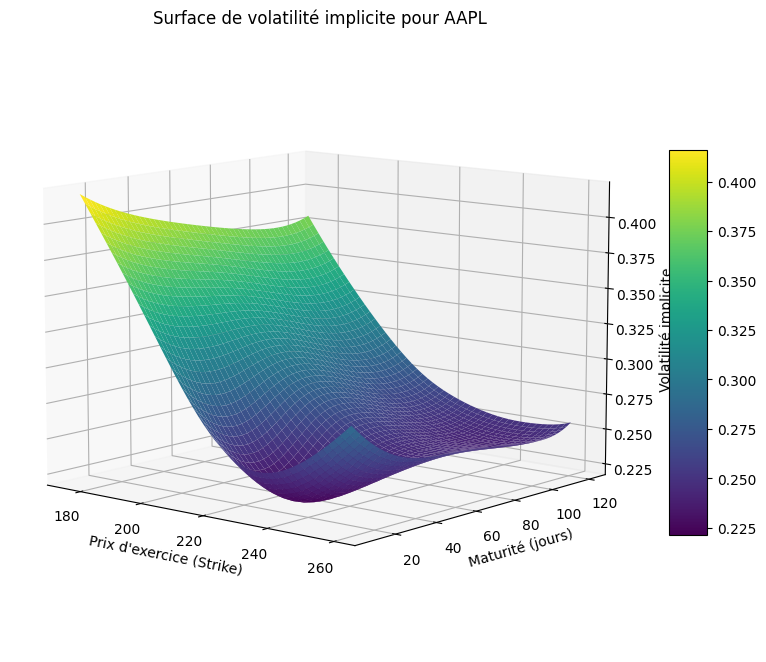

,strike,T(d),IV_NR,IV_Interpolated
216,220.0,9,0.271332,0.261231
524,200.0,30,0.328359,0.311880
525,200.0,30,0.273346,0.311880
527,205.0,30,0.257227,0.290675
528,210.0,30,0.281461,0.270873


In [76]:
# Exemple d'utilisation
OptionsDF = PlotVolatilitySurface(OptionsDF, Smoothing=0.01)
OptionsDF[['strike', 'T(d)', 'IV_NR', 'IV_Interpolated']].head()

---

### IV — Surface de Volatilité avec Lissage Optimal

Pour obtenir une représentation plus fidèle de la surface de volatilité, nous optimisons le paramètre de lissage. Cette calibration vise à minimiser l'écart entre les valeurs interpolées et les volatilités implicites observées sur le marché.

La fonction `CalculateError` mesure d'abord l'écart entre les volatilités implicites observées et celles interpolées pour un paramètre de lissage donné.  

La fonction `CalibrateSurface` utilise ensuite l'algorithme d'optimisation de Nelder-Mead pour ajuster le paramètre de lissage. Elle cherche à minimiser les erreurs entre les volatilités observées et celles interpolées, assurant ainsi une meilleure représentation de la surface de volatilité. L'algorithme est particulièrement efficace pour ce type d'optimisation car il ne nécessite pas le calcul de dérivées et peut fonctionner avec des fonctions non linéaires et bruitées, ce qui est souvent le cas avec les données financières

In [77]:
# Calibration de la surface de volatilité en optimisant le paramètre de lissage
def CalibrateSurface(OptionsDF, InitialSmoothing=0.5):
    
    def CalculateError(Smoothing):
        
        _, _, _, TempDF = InterpolateVolatilitySurface(OptionsDF, Smoothing)
        Errors = (OptionsDF['IV_NR'] - TempDF['IV_Interpolated'])**2
        
        return np.mean(Errors)
    
    # Optimisation du paramètre de lissage
    Result = minimize(CalculateError, [InitialSmoothing], method='Nelder-Mead')
    OptimalSmoothing = Result.x[0]
    
    # Recalcul de la surface avec le lissage optimal
    GridX, GridY, GridZ, OptionsDF = InterpolateVolatilitySurface(OptionsDF, OptimalSmoothing)
    
    # Création d'un DataFrame avec la surface interpolée
    GridDF = pd.DataFrame({
        'strike': GridX.flatten(),
        'T(d)': GridY.flatten(),
        'IV_Surface': GridZ.flatten()
    })
    GridDF['Ticker'] = OptionsDF['Ticker'].iloc[0]
    GridDF['S'] = OptionsDF['S'].iloc[0]
    
    return OptimalSmoothing, OptionsDF, GridDF

Lissage optimal: -0.054296875000000494


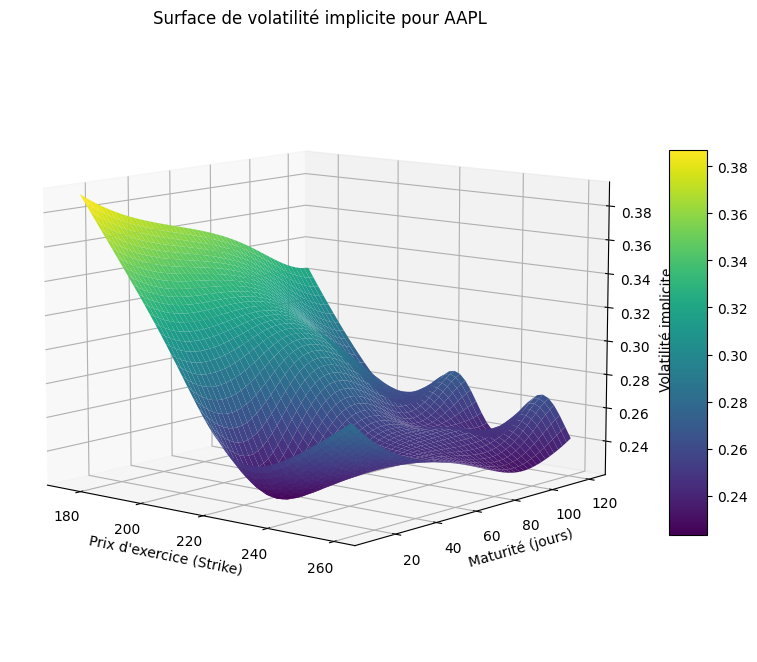

,strike,T(d),IV_NR,IV_Interpolated
216,220.0,9,0.271332,0.258298
524,200.0,30,0.328359,0.310812
525,200.0,30,0.273346,0.310812
527,205.0,30,0.257227,0.295631
528,210.0,30,0.281461,0.275872


In [78]:
# Utilisation de la fonction
OptimalSmoothing, OptionsDF, GridDF = CalibrateSurface(OptionsDF, InitialSmoothing=0.5)
print(f"Lissage optimal: {OptimalSmoothing}")

# Tracé de la surface avec le lissage optimal
PlotVolatilitySurface(OptionsDF, Smoothing=OptimalSmoothing)
OptionsDF[['strike', 'T(d)', 'IV_NR', 'IV_Interpolated']].head()

---

### V — Structure par Terme de la Volatilité

La **structure par terme de la volatilité** représente en 2D la volatilité implicite $\sigma(T)$ pour différents prix d'exercice $K$ fixes. Elle montre comment la volatilité implicite varie en fonction du temps jusqu'à l'échéance.

**Caractéristiques :**

1. **Courbe ascendante** : $\sigma$ augmente avec $T$ (cas typique).
2. **Courbe descendante** : $\sigma$ diminue avec $T$ (rare, généralement en période de marché stressé).
3. **Courbe en "bosse"** : $\sigma$ atteint un pic pour une maturité $T$ intermédiaire.

La fonction `VolatilityTermStructure` permet de visualiser ces tendances en traçant la volatilité implicite en fonction du temps jusqu'à l'échéance pour plusieurs prix d'exercice.

In [79]:
# Tracé de la structure par terme de la volatilité
def VolatilityTermStructure(GridDF, Percentiles=[10, 25, 50, 75, 90]):
    
    Strikes = GridDF['strike'].unique()
    plt.figure(figsize=(10, 5))
    
    for P in np.percentile(Strikes, Percentiles):
        
        NearestStrike = Strikes[np.argmin(np.abs(Strikes - P))]
        Subset = GridDF[GridDF['strike'] == NearestStrike]
        
        if not Subset.empty:
            plt.plot(Subset['T(d)'], Subset['IV_Surface'] * 100, 
                     label=f'Strike: {NearestStrike:.2f}',
                     linewidth=2)
    
    plt.xlabel('Maturité (jours)')
    plt.ylabel('Volatilité implicite (%)')
    plt.title(f"Structure par terme de la volatilité ({GridDF['Ticker'].iloc[0]})")
    plt.legend( loc='best')
    plt.grid(True)
    plt.show()

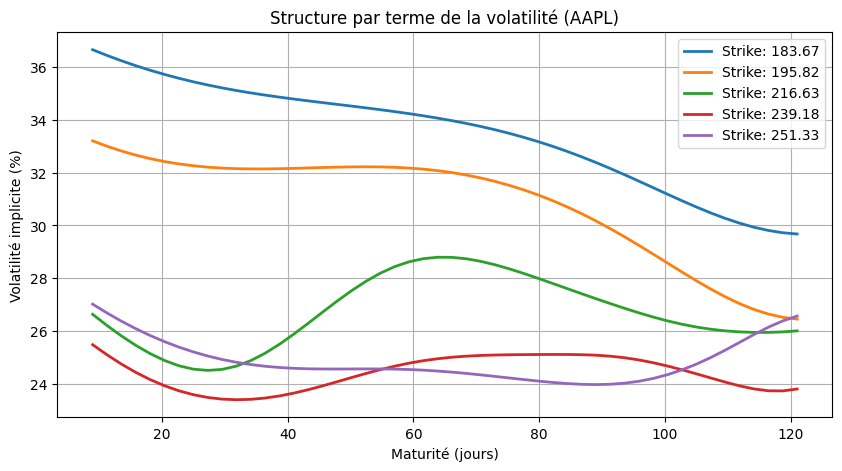

In [80]:
# Utilisation de la fonction
VolatilityTermStructure(GridDF, Percentiles=[10, 25, 50, 75, 90])

---
### VI — Grecques & Profit et Perte (P&L)

#### 1. Calcul des Grecques

Les **Grecques** mesurent la sensibilité du prix d'une option par rapport à différents paramètres du marché. Elles sont essentielles pour la gestion des risques associés à un portefeuille d'options.

- **Delta (Δ)** : Sensibilité du prix de l'option au changement du prix du sous-jacent.

$$\Delta_{\text{call}} = N(d_1)$$\
$$\Delta_{\text{put}} = N(d_1) - 1$$

- **Gamma (Γ)** : Taux de changement du delta par rapport au prix du sous-jacent. (Identique pour les calls et les puts)

$$\Gamma = \frac{N'(d_1)}{S \sigma \sqrt{T}}$$

- **Theta (Θ)** : Sensibilité du prix de l'option au passage du temps.

$$\Theta_{\text{call}} = -\frac{S N'(d_1) \sigma}{2 \sqrt{T}} - r K e^{-r T} N(d_2)$$\
$$\Theta_{\text{put}} = -\frac{S N'(d_1) \sigma}{2 \sqrt{T}} + r K e^{-r T} N(-d_2)$$

- **Vega (ν)** : Sensibilité du prix de l'option à la volatilité.

$$\nu = S \sqrt{T} N'(d_1)$$

- **Rho (ρ)** : Sensibilité du prix de l'option au taux d'intérêt.

$$\rho_{\text{call}} = K T e^{-r T} N(d_2)$$\
$$\rho_{\text{put}} = -K T e^{-r T} N(-d_2)$$

Où :
- $N(x)$ est la fonction de répartition de la loi normale centrée réduite.
- $N'(x)$ est la densité de la loi normale centrée réduite.
- $d_1$ et $d_2$ sont définis comme précédemment.

La fonction `CalculateGreeks` calcule ces sensibilités pour une option donnée selon le modèle de Black-Scholes.

#### 2. Analyse et Visualisation des Grecques et du P&L

La fonction `AnalyzeOption` permet d'analyser une option en fonction des Grecques et du P&L, en calculant comment ces valeurs évoluent pour différentes valeurs du sous-jacent.

Elle trace les courbes des Grecques (Delta, Gamma, Theta, Vega, Rho) et le profit ou la perte potentiel en fonction du prix du sous-jacent. Cela permet de visualiser l'impact des variations du marché sur l'option.

---

In [81]:
# Calcul des grecques selon le modèle de Black-Scholes
def CalculateGreeks(S, K, T, r, Sigma, OptionType='C'):
    d1 = (np.log(S / K) + (r + 0.5 * Sigma**2) * T) / (Sigma * np.sqrt(T))
    d2 = d1 - Sigma * np.sqrt(T)
    
    if OptionType == 'C':
        Delta = norm.cdf(d1)
        Theta = (-S * norm.pdf(d1) * Sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(d2)) / 252
        Rho = K * T * np.exp(-r * T) * norm.cdf(d2) / 100
    else:
        Delta = norm.cdf(d1) - 1
        Theta = (-S * norm.pdf(d1) * Sigma / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * norm.cdf(-d2)) / 252
        Rho = -K * T * np.exp(-r * T) * norm.cdf(-d2) / 100
    
    Gamma = norm.pdf(d1) / (S * Sigma * np.sqrt(T))
    Vega = BlackAndScholesVega(S, K, T, r, Sigma) / 100
    
    return Delta, Gamma, Theta, Vega, Rho

In [82]:
def AnalyzeOption(GridDF, K, T, r, OptionType='C'):
    
    # Trouver la volatilité implicite pour le strike et la maturité donnés
    OptionRow = GridDF.loc[(np.abs(GridDF['strike'] - K) + np.abs(GridDF['T(d)']/365 - T)).idxmin()]
    
    S = GridDF['S'].unique()[0]
    Sigma = OptionRow['IV_Surface']
    
    # Calcul du prix de l'option
    OptionPrice = BlackAndScholesPrice(S, K, T, r, Sigma, OptionType)
    
    # Plage de prix pour le sous-jacent
    SRange = np.linspace(0.5 * S, 1.5 * S, 100)
    
    Greeks = {'Delta': [], 'Gamma': [], 'Theta': [], 'Vega': [], 'Rho': []}
    PayoffLong = []
    PayoffShort = []
    
    for s in SRange:
        Delta, Gamma, Theta, Vega, Rho = CalculateGreeks(s, K, T, r, Sigma, OptionType)
        Greeks['Delta'].append(Delta)
        Greeks['Gamma'].append(Gamma)
        Greeks['Theta'].append(Theta)
        Greeks['Vega'].append(Vega)
        Greeks['Rho'].append(Rho)
        
        # Calcul des P&L pour les positions long et short
        IntrinsicValue = max(s - K, 0) if OptionType == 'C' else max(K - s, 0)
        PayoffLong.append(IntrinsicValue - OptionPrice)
        PayoffShort.append(OptionPrice - IntrinsicValue)
    
    # Tracé des Grecques et du Payoff
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    GreekNames = ['Delta', 'Gamma', 'Theta', 'Vega', 'Rho']
    
    for i, name in enumerate(GreekNames):
        ax = axes.flat[i]
        ax.plot(SRange, Greeks[name], label=name, color='black', linestyle='-', linewidth=1)
        ax.set_xlabel('Prix du sous-jacent')
        ax.set_title(f'{name}')
        ax.grid(True)
        ax.axvline(x=S, color='blue', linestyle='-', linewidth=1, label='Prix actuel')
        ax.axvline(x=K, color='red', linestyle='-', linewidth=1, label='Prix d\'exercice')
        ax.grid(False)
        ax.minorticks_on()
        
        if name == 'Delta':
            ax.legend()
    
    # Ajout du plot de Payoff 
    ax_payoff = axes.flat[5]
    ax_payoff.plot(SRange, PayoffLong, label='Payoff Long', color='black', linestyle='-', linewidth=1)
    ax_payoff.plot(SRange, PayoffShort, label='Payoff Short', color='black', linestyle='--', linewidth=1)
    ax_payoff.set_xlabel('Prix du sous-jacent')
    ax_payoff.set_ylabel('Payoff')
    ax_payoff.set_title(f'Payoff Long vs Short {OptionType}')
    ax_payoff.axhline(y=0, color='black', linestyle='-', linewidth=1)
    ax_payoff.axvline(x=S, color='blue', linestyle='-', linewidth=1, label='Prix actuel')
    ax_payoff.axvline(x=K, color='red', linestyle='-', linewidth=1, label='Strike')
    ax_payoff.legend()
    ax_payoff.grid(False)
    ax_payoff.minorticks_on()

    
    plt.tight_layout()
    plt.suptitle(f"Analyse de l'option {OptionType} (S={S:.2f}, K={K}, T={T:.2f}, σ={Sigma:.4f}, r={r:.2f}, Prix={OptionPrice:.2f})", y=1.02)
    plt.show()
   
    print(f"Option Type: {OptionType}, K={K}, T={T:.2f}")
    print(f"Delta={Delta:.4f};\nGamma={Gamma:.4f};\nTheta={Theta:.4f};\nVega={Vega:.4f};\nRho={Rho:.4f}")

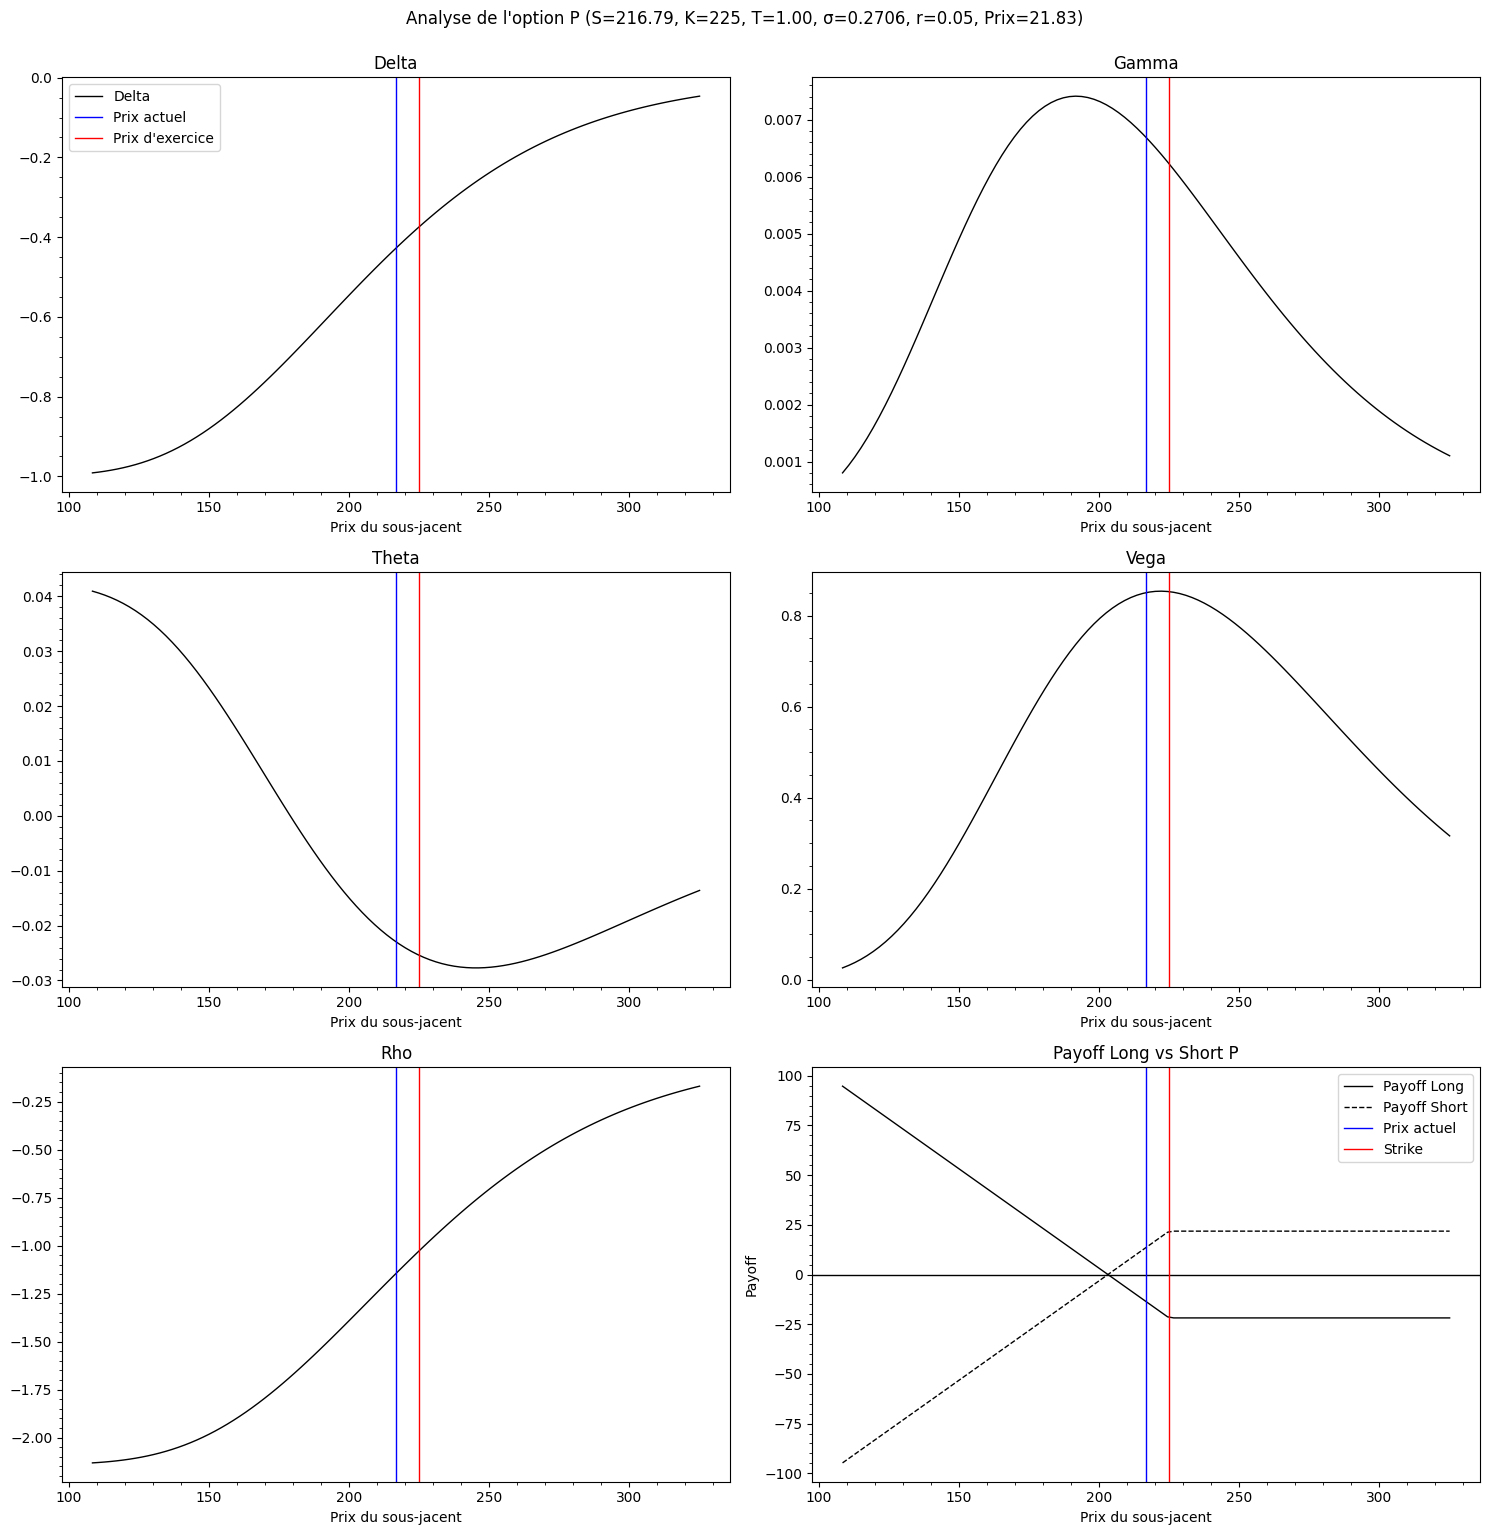

Option Type: P, K=225, T=1.00
Delta=-0.0464;
Gamma=0.0011;
Theta=-0.0136;
Vega=0.3158;
Rho=-0.1695


In [83]:
# Utilisation de la fonction
AnalyzeOption(GridDF, K=225, T=1, r=0.05, OptionType='P')